[1] Dynamics of offshore structures, J. F. Wilson (Chapter 10)

In [1]:
import numpy as np
from random import  uniform
from sympy import diff, Symbol,lambdify, solve, cos, pi
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
A = 0.78
B = 0.0311
B0 = 122
c = 5.55
CA = 1
CM = 2
d = 1067
D = 9.144
e1 = 0.093
e2 = 0.05
E = 2.07e11
EI = 3.94e11
g = 9.81
K = 1.13e8
L = 1037 
M0 = 4.54e4 # or 2.27e5
M1 = 0.6*M0
m_hat = 6.43e4
m1_hat = 1.25e3
N = 15
rho = 962
omega1 = 0.1
omega_b = 0.503
omega_N = 1.5
omega_p = 0.4

In [3]:
# Pierson-Moskowitz spectrum
def S_eta(omega):
    return A*omega**(-5)*np.exp(-B/omega**4)

In [4]:
def eta(omega_n, del_omega):
    return (2*S_eta(omega_n)*del_omega)**0.5

In [5]:
eta(omega_N, omega_N/N)

0.14288945193592165

In [6]:
def R(omega_n):
    if 0<omega_n<=omega_b :
        return 1
    elif omega_b<omega_n<=omega_N:
        return 1-(omega_n-omega_b)/(omega_N-omega_b)
    else:
        return 0

In [7]:
# heave motion of the barge
def H(t, del_omega):
    return np.sum([R(i*del_omega)*eta(i*del_omega,del_omega)*cos(i*del_omega*t+uniform(0, 2*pi)) 
                   for i in range(1,N+1)])

In [8]:
def P(x,t, del_omega):
    x_=Symbol('x_')
    t_=Symbol('t_')
    def P_(x_,t_, del_omega):
        return M1*g + (L-x_)*m1_hat*g + (L-x_)*m_hat*diff(H(t_, del_omega),t_,2) + M0*diff(H(t_, del_omega),t_,2)
    return lambdify((x_, t_), P_(x_,t_,del_omega), 'numpy')(x,t)

In [9]:
# sway motion of the barge
def S(t, del_omega):
    return (eta(omega_p, del_omega)*np.sin(e1*omega_p*t+uniform(0, 2*np.pi))+
            np.sum([e2*eta(i*del_omega,del_omega)*np.sin(e1*i*del_omega*t+uniform(0, 2*np.pi))
                    for i in range(int(omega_p/del_omega+1),N+1)]))

In [10]:
def q_hat(t, x, del_omega, ddv):
    z = -x 
    
    def du(z,t,del_omega):
        return np.sum( [(i*del_omega)**2*eta(i*del_omega, del_omega)*np.exp((i*del_omega)**2/g*(z+d))*np.sin(i*del_omega*t+uniform(0, 2*np.pi))/np.sinh((i*del_omega)**2/g*d)
                   for i in range(1,N+1)])
    
    return 1.1*0.25*np.pi*CM*rho*D**2*du(z,t,del_omega)-0.25*np.pi*CA*rho*D**2*ddv

In [11]:
q_hat(0.1, 10, omega_N/N, .015)

-132388.70138571534

### Finite difference solution

In [12]:
# EI*ddddv_ddddx-dP_dx*dv_dx-P*ddv_ddx+m_hat*ddv=q_hat(x,t)

In [13]:
T = 600  # Maximum time bound
del_t = 2
m = 50  # No. of intervals in space
n = int(T/del_t)  # No. of intervals in time
h = L / m  # Step size in space
k = T / n  # Step size in time

In [14]:
# Initialization of solution
v = np.zeros((m + 1, n + 1))

# Initial condition
ic1 = lambda t: S(t, omega_N/N)  # produces slight variability when called twice in Space discretization below

# Space discretization
for j in range(1, n + 2):
    ic = ic1((j - 1) * k)
    v[0, j - 1] = ic
    v[1, j - 1] = ic

In [15]:
v.shape

(51, 301)

In [16]:
def ddddv_ddddx(y0,y1,y2,y3,y4,h):
    return (y0-4*y1+6*y2-4*y3+y4)/h**4

In [17]:
def ddv_ddx(y1,y2,y3, h):
    return (y3-2*y2+y1)/h**2

In [18]:
def dv_dx(y1,y3,h):
    return (y3-y1)/(2*h)

In [19]:
def dP_dx(x1,x3,h,t,del_omega):
    return (P(x3,t,del_omega)-P(x1,t,del_omega))/(2*h)

In [20]:
def gov_eq(y0, y1, y2, y3, y4, t1, t3, h, k, x,t):
    d_omega=omega_N/N
    return (EI*ddddv_ddddx(y0,y1,y2,y3,y4,h)
            - dP_dx(x-h,x+h,h,t,d_omega)*dv_dx(y1,y3,h)
            - P(x,t,d_omega)*ddv_ddx(y1,y2,y3, h)
            + m_hat*ddv_ddx(t1,y2,t3, k)
            - q_hat(t, x, d_omega, ddv_ddx(t1,y2,t3, k)))

In [21]:
y2=Symbol('y2')

In [22]:
startTime1 = datetime.now()
for j in range(1, n):
    for i in tqdm(range(2, m-1)): # the range must start from i=2 ?
        v[i][j] = solve(gov_eq(v[i - 2, j], v[i - 1, j], y2, v[i +1, j], v[i + 2, j], v[i , j-1], v[i , j+1], h, k, i*h,j*k), y2)[0]
print(datetime.now() - startTime1)

100%|███████████████████████████████████████████| 47/47 [00:21<00:00,  2.20it/s]


100%|███████████████████████████████████████████| 47/47 [00:21<00:00,  2.20it/s]


100%|███████████████████████████████████████████| 47/47 [00:21<00:00,  2.16it/s]

1:48:10.558440


In [23]:
np.max(v)

2.2682462187265258

In [24]:
ind = np.unravel_index(np.argmax(v, axis=None), v.shape)

In [25]:
ind

(0, 293)

In [26]:
if np.max(v)/L<1:
    print("Stable")
else:
    print("Unbounded pipe response")

Stable


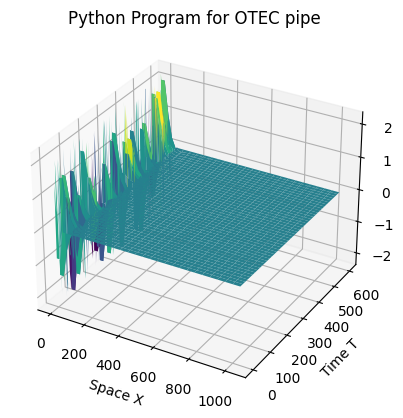

In [27]:
# Visualization
x_ = np.linspace(0, L, m + 1 )
t_ = np.linspace(0, T, n + 1)
X, T = np.meshgrid(x_, t_)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, v.T, cmap='viridis')
ax.set_xlabel('Space X')
ax.set_ylabel('Time T')
ax.set_zlabel('V')
plt.title('Python Program for OTEC pipe')
plt.show()

In [28]:
np.max(v[2])

1.1468139037504275

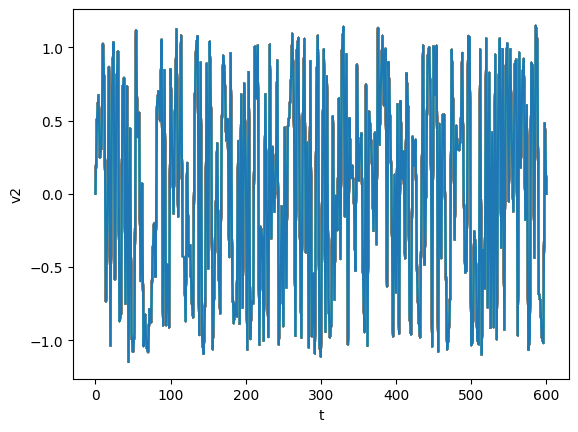

In [29]:
plt.plot(T,v[2] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(2))
plt.show()

In [30]:
np.max(v[3])

0.38668127424505533

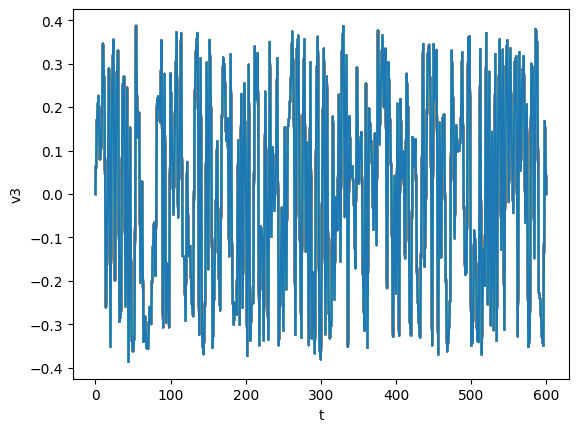

In [31]:
plt.plot(T,v[3] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(3))
plt.show()

In [32]:
np.max(v[4])

0.07508513405586176

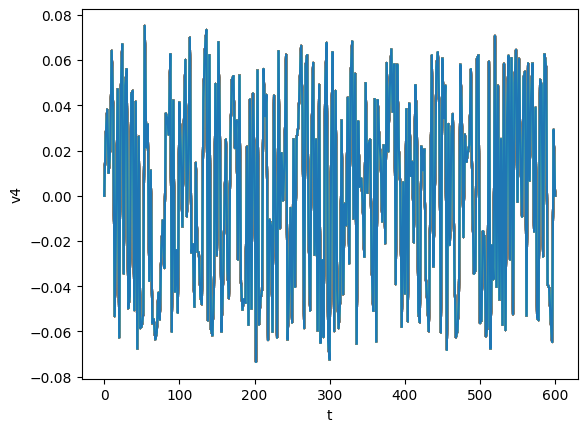

In [33]:
plt.plot(T,v[4] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(4))
plt.show()

In [34]:
np.max(v[5])

0.02220953783004581

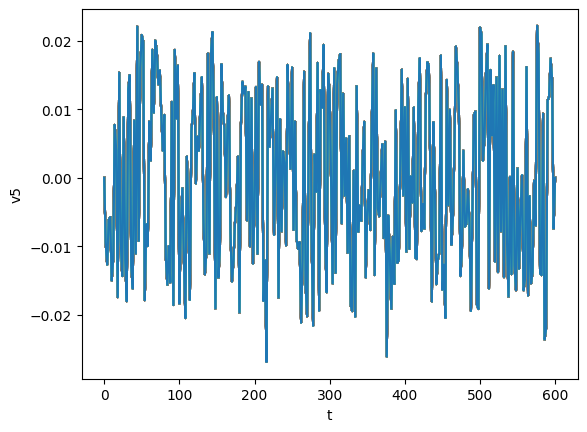

In [35]:
plt.plot(T,v[5] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(5))
plt.show()

In [36]:
np.max(v[10])

0.001062976234883341

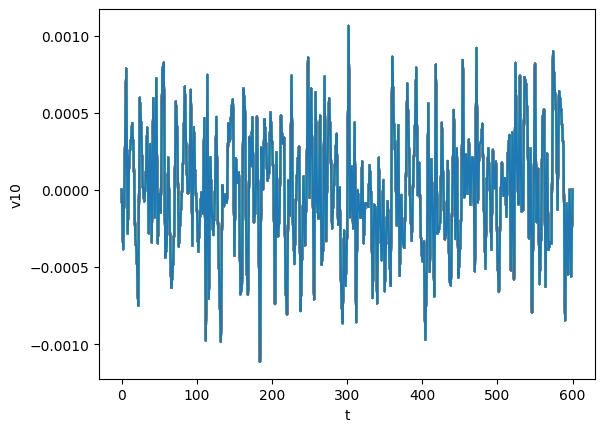

In [37]:
plt.plot(T,v[10] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(10))
plt.show()

In [38]:
np.max(v[15])

0.00032038137257629556

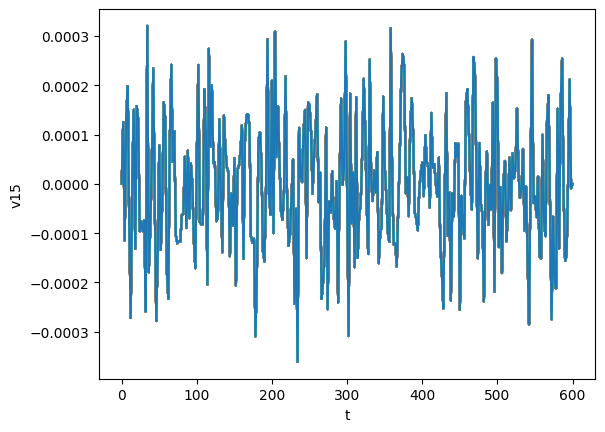

In [39]:
plt.plot(T,v[15] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(15))
plt.show()

In [40]:
np.max(v[20])

0.00012326932400930969

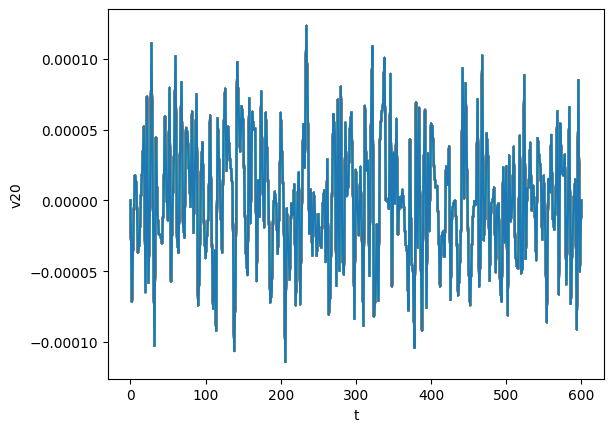

In [41]:
plt.plot(T,v[20] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(20))
plt.show()

In [42]:
np.max(v[m-3])

6.70586070316435e-07

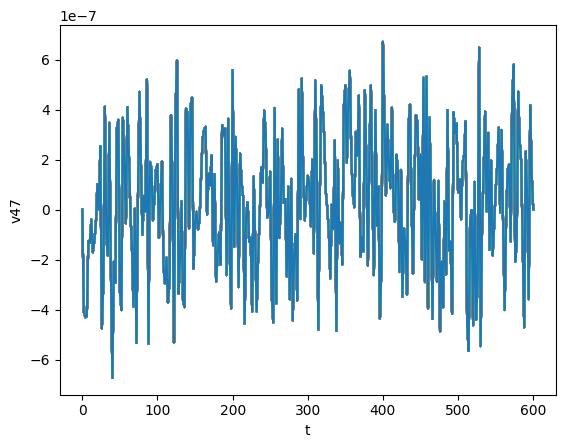

In [43]:
plt.plot(T,v[m-3] ,'-')
plt.xlabel('t')
plt.ylabel('v{}'.format(m-3))
plt.show()

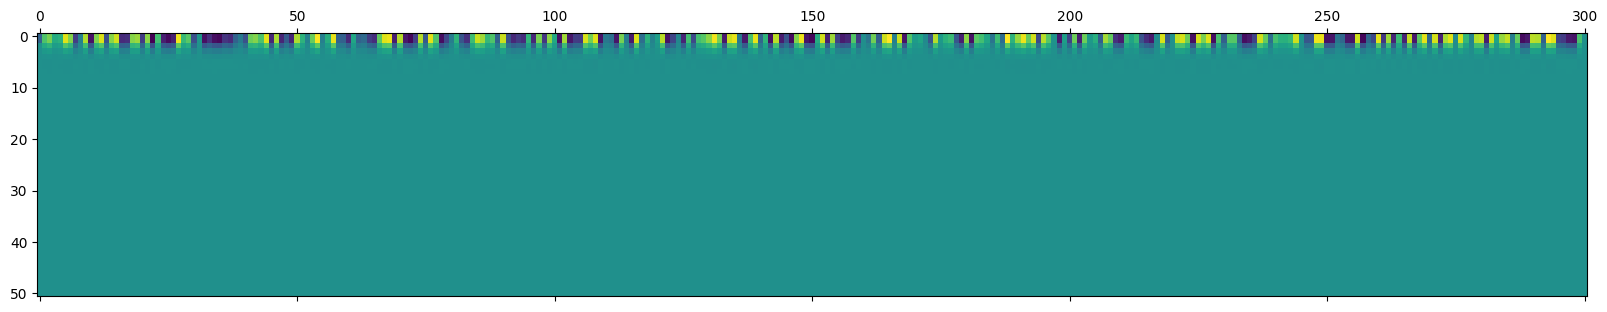

In [44]:
plt.figure(figsize=(20,20))
plt.matshow(v, fignum=1)

In [45]:
# for moments use equation 10.135 with initial conditions 10.125 and 10.126 